In [1]:
import sys
sys.path.append('..')

# MultiForecast

In [2]:
from spinesTS.data import *
from spinesTS.preprocessing import split_series
from spinesTS.ml_model import MultiOutputRegressor, MultiStepRegressor

from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

In [3]:
electric = LoadElectricDataSets()
ds = electric['value']
x_train, x_test, y_train, y_test = split_series(ds, ds, 10, 30, train_size=0.8)

In [4]:
msf = MultiStepRegressor(LGBMRegressor())
mof = MultiOutputRegressor(LGBMRegressor(), n_jobs=-1)

In [5]:
msf.fit(x_train, y_train)
mof.fit(x_train, y_train)
y_pred_msf = msf.predict(x_test)
y_pred_mof = mof.predict(x_test)
r2_score(y_test.T, y_pred_msf.T), r2_score(y_test.T, y_pred_mof.T)

(0.6850649543583034, 0.8053237748779316)

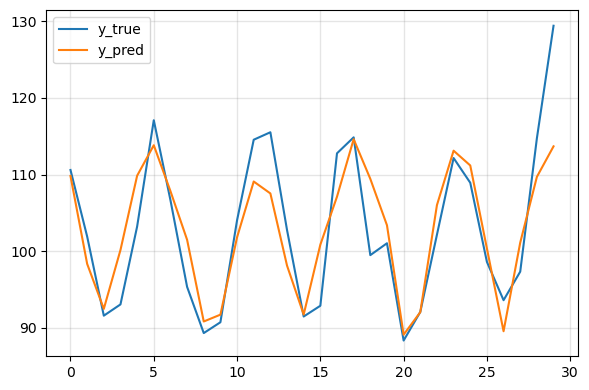

In [6]:
a = plot2d(y_test, y_pred_mof, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

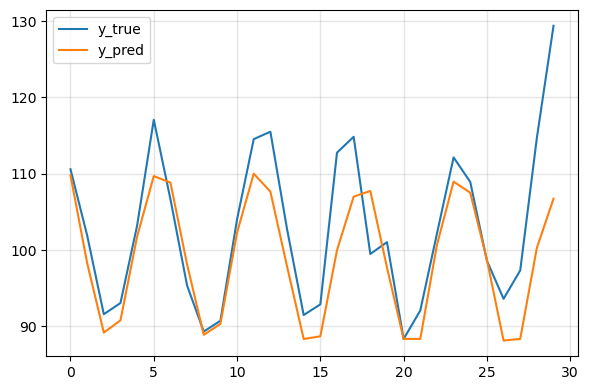

In [7]:
a = plot2d(y_test, y_pred_msf, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

# Pipeline

In [8]:
from spinesTS.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])

In [10]:
multi_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)

In [11]:
y_pred = multi_reg.predict(x_test)

In [12]:
r2_score(y_test.T, y_pred.T)

0.8068726243223835

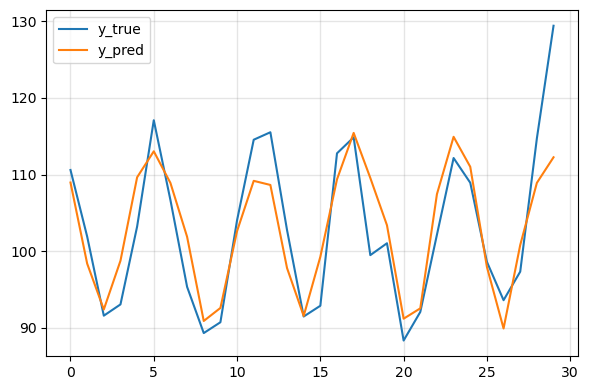

In [13]:
a = plot2d(y_test, y_pred, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

## other algorithm pipeline

In [14]:
from spinesTS.data import LoadSupermarketIncoming
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

In [15]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")

r2: 0.8055589089422277
mae: 3.1094190438053237
mape: 0.029791289699066813


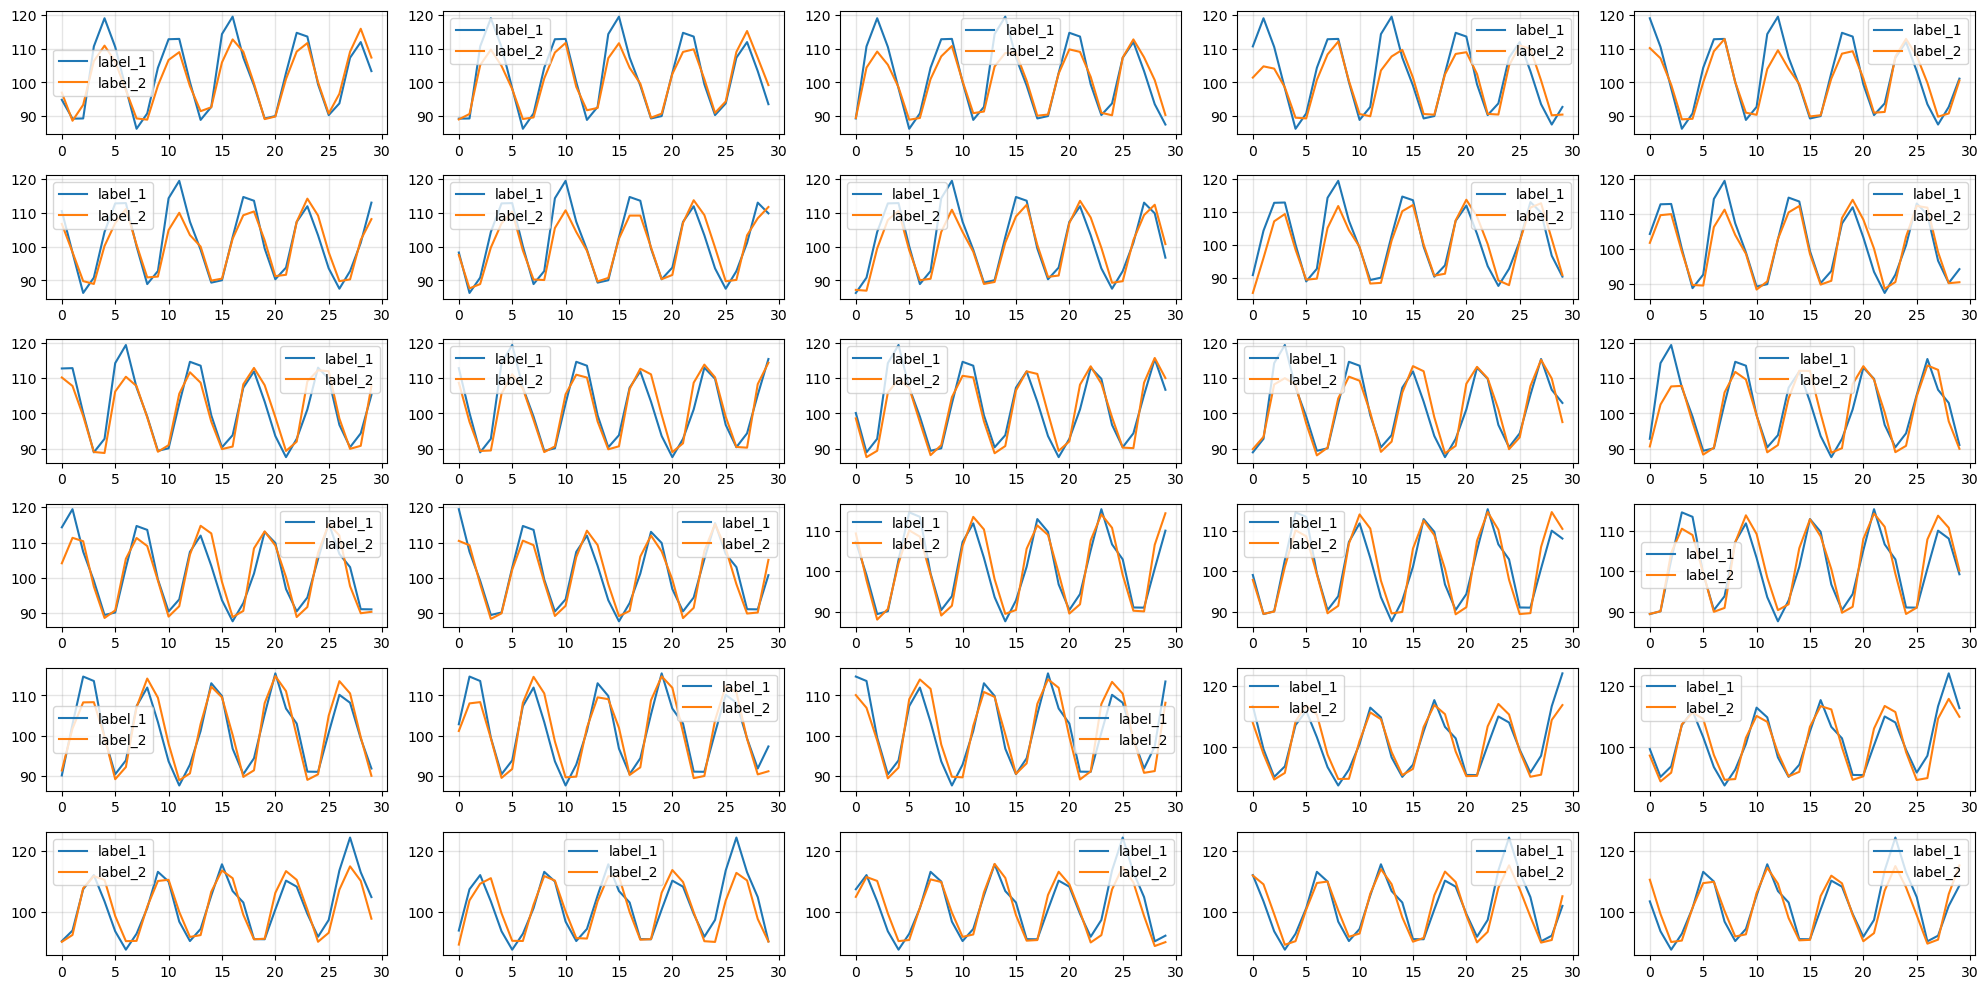

In [16]:
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

## feature generate

r2: 0.8201404479498705
mae: 3.0386286307417256
mape: 0.028823986914780435


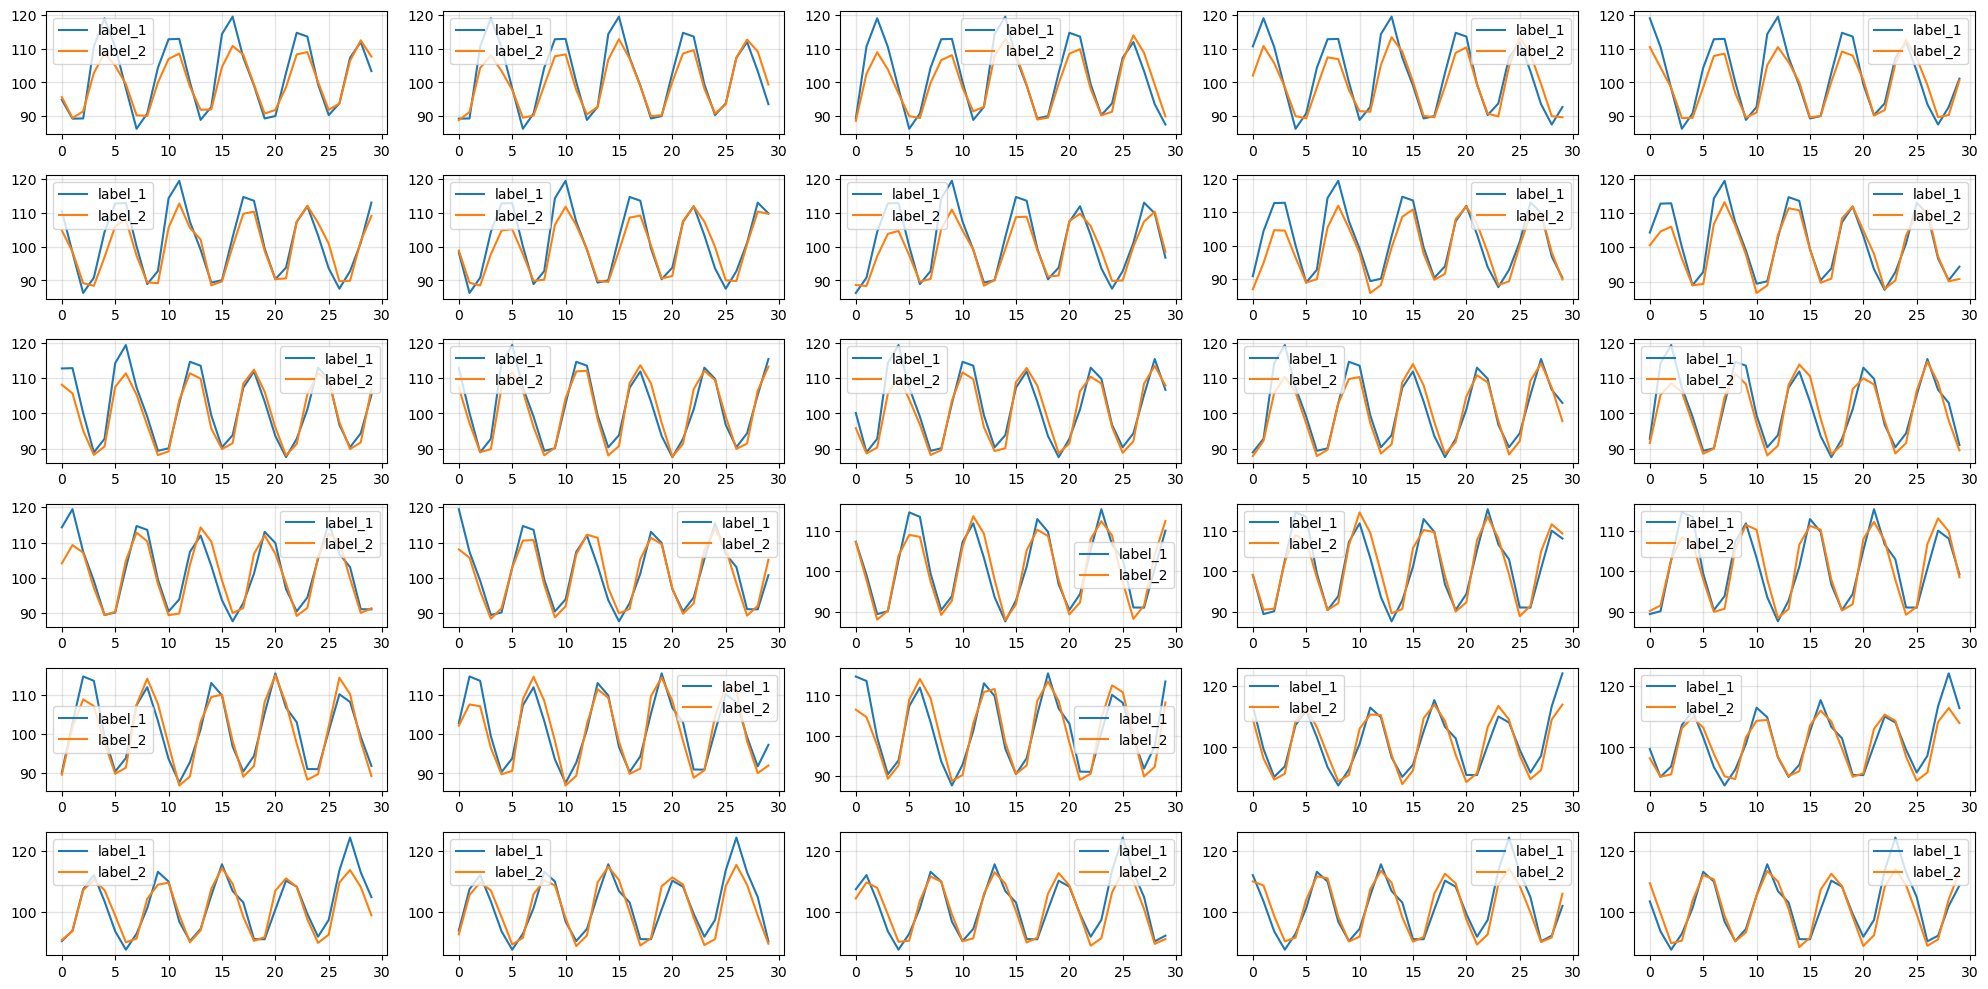

In [17]:
from spinesTS.features_generator import ContinuousFeatureGenerator
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.8280180006456318
mae: 3.005483508137291
mape: 0.028610359084774675


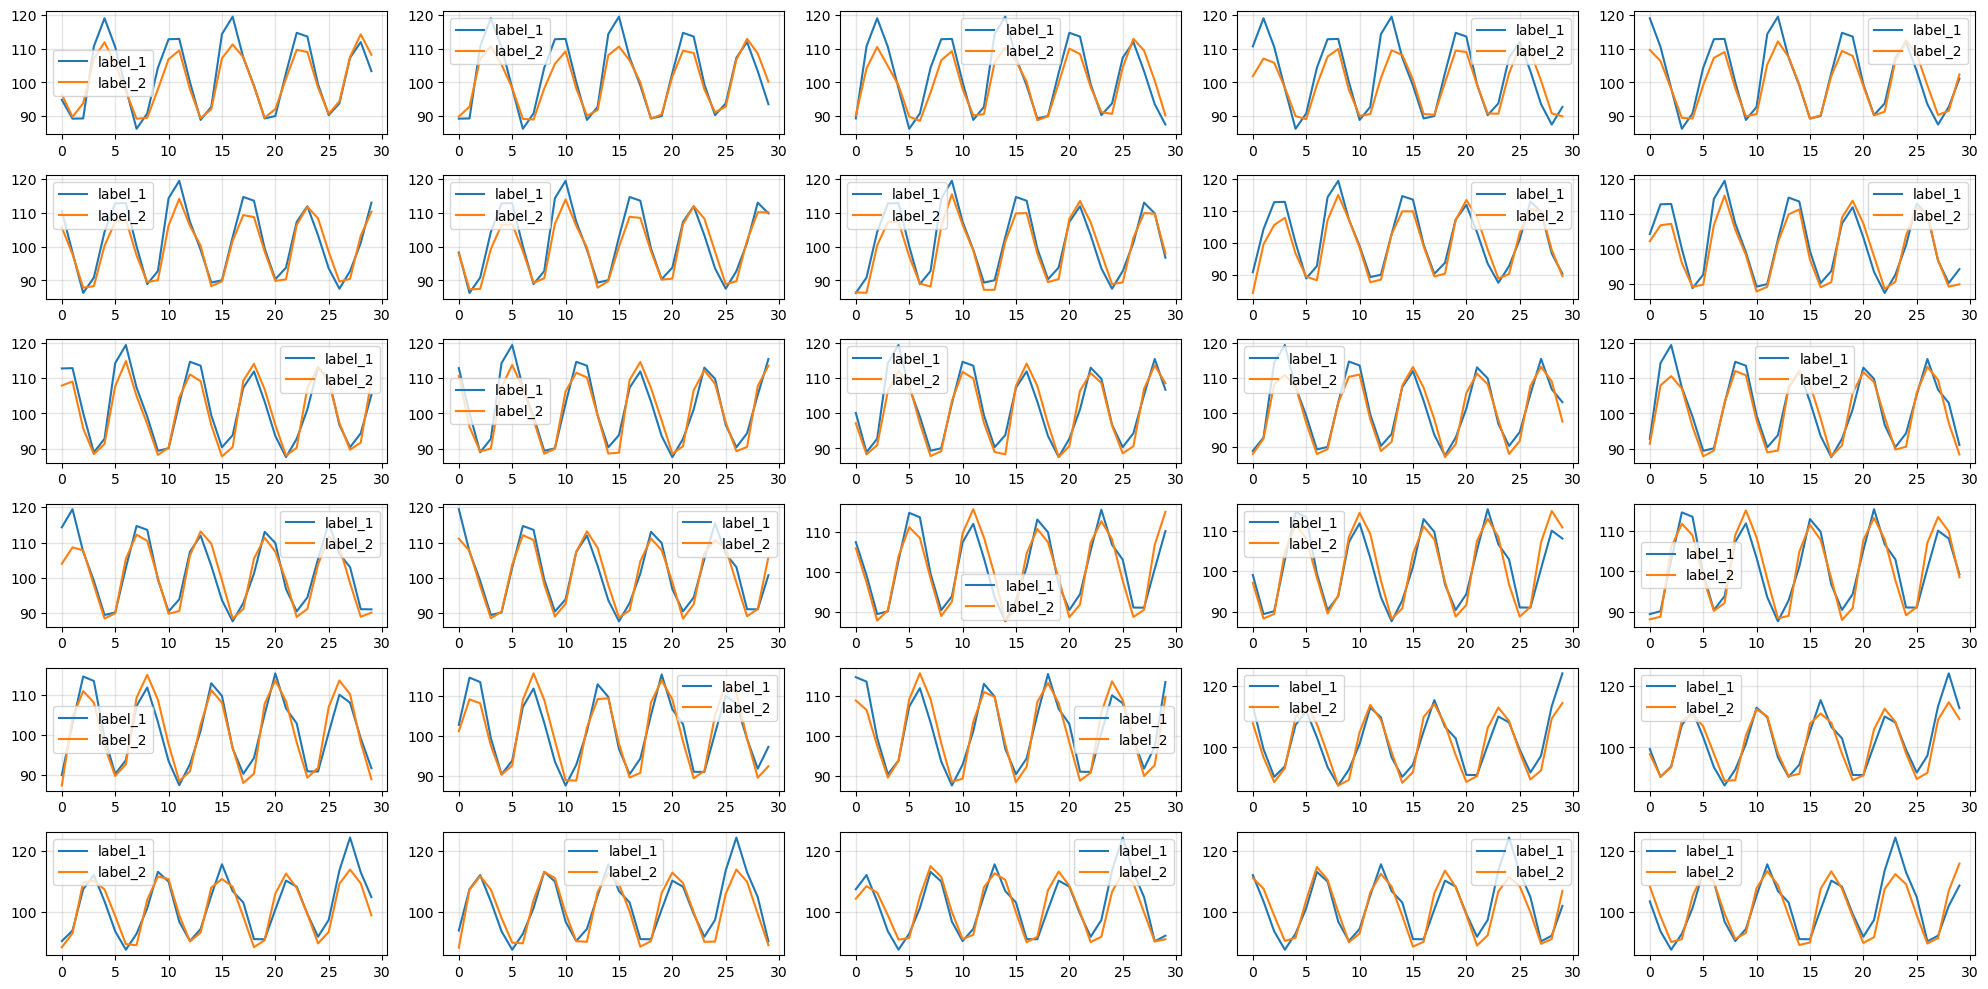

In [18]:
from spinesTS.metrics import *
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.8214340982427908
mae: 3.0303603572055993
mape: 0.028751928463021208


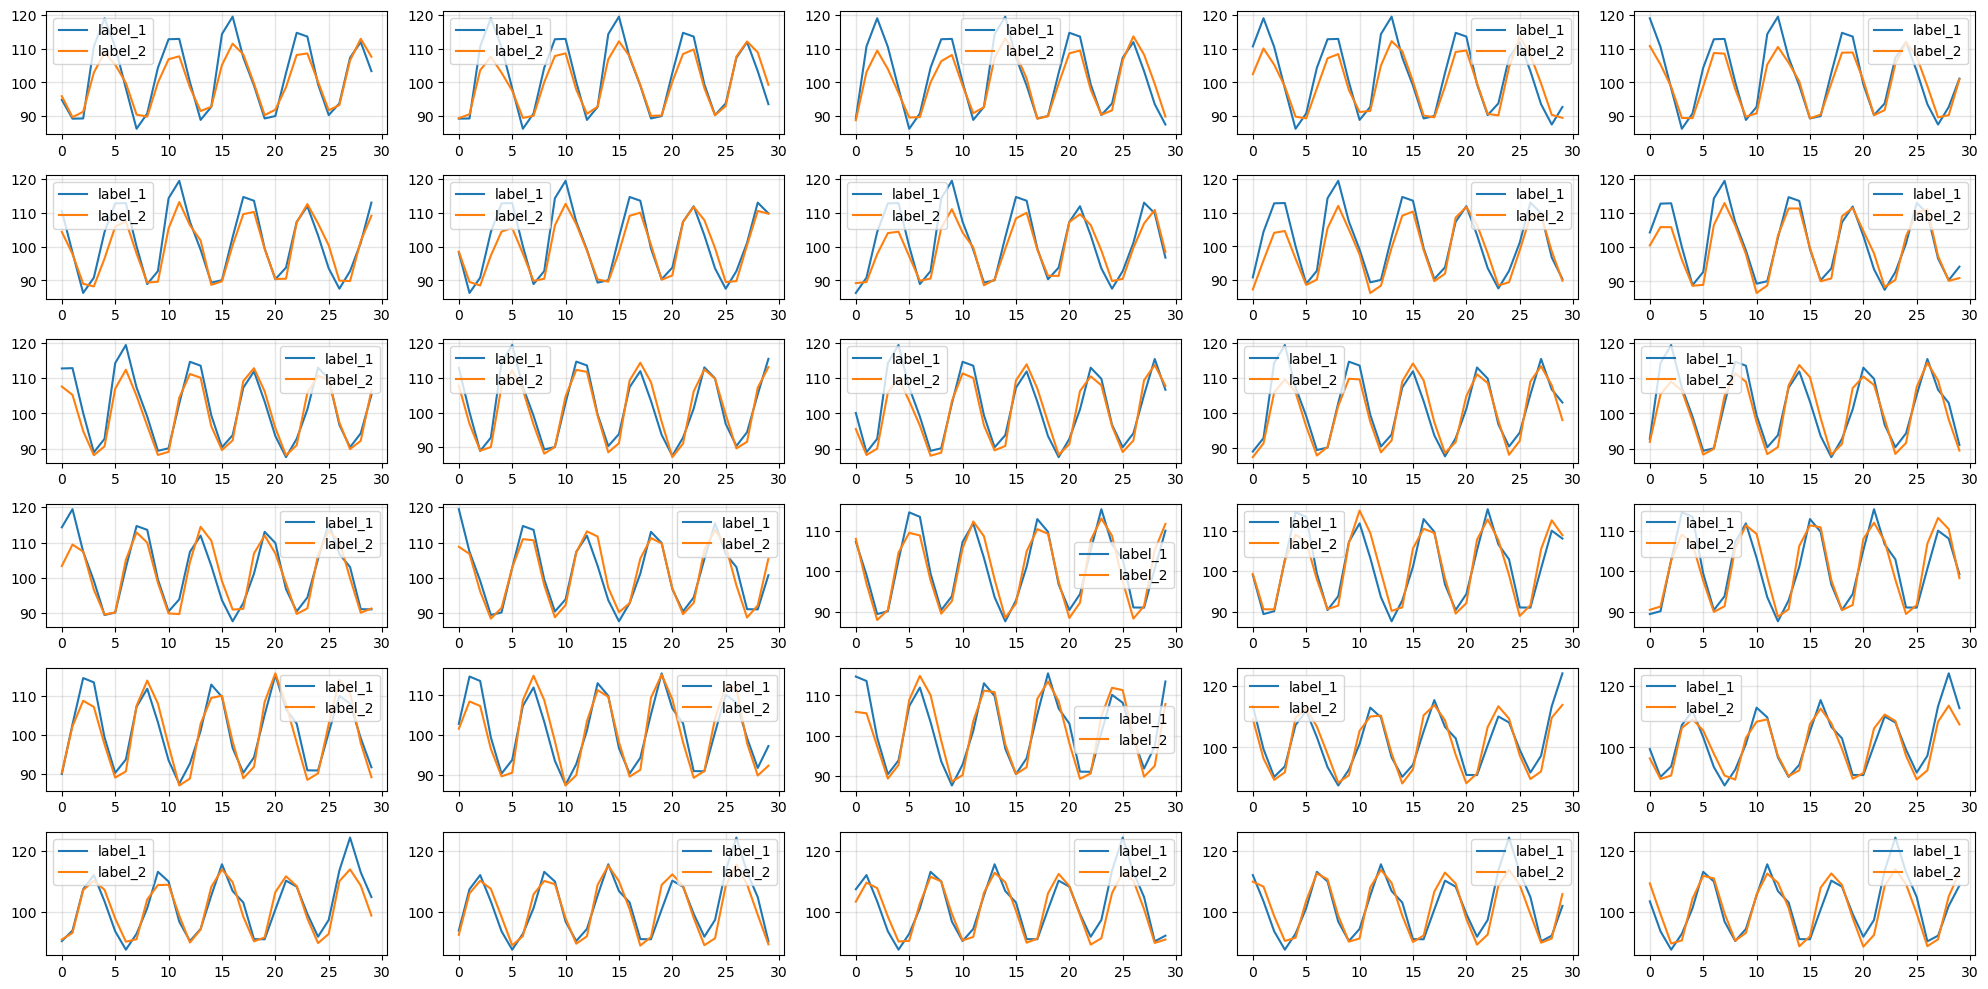

In [19]:
from spinesTS.metrics import *
from spinesTS.features_generator import ContinuousFeatureGenerator
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

# GBRT

In [4]:
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT

In [5]:
gbrt_processor = GBRTPreprocessing(128, 24, 'value', date_col='date')
gbrt_processor.fit(electric)

In [6]:
x_train, x_test, y_train, y_test = gbrt_processor.transform(electric)

r2: 0.8378931556116094
mae: 2.853177648303205
mape: 0.026808663773659706


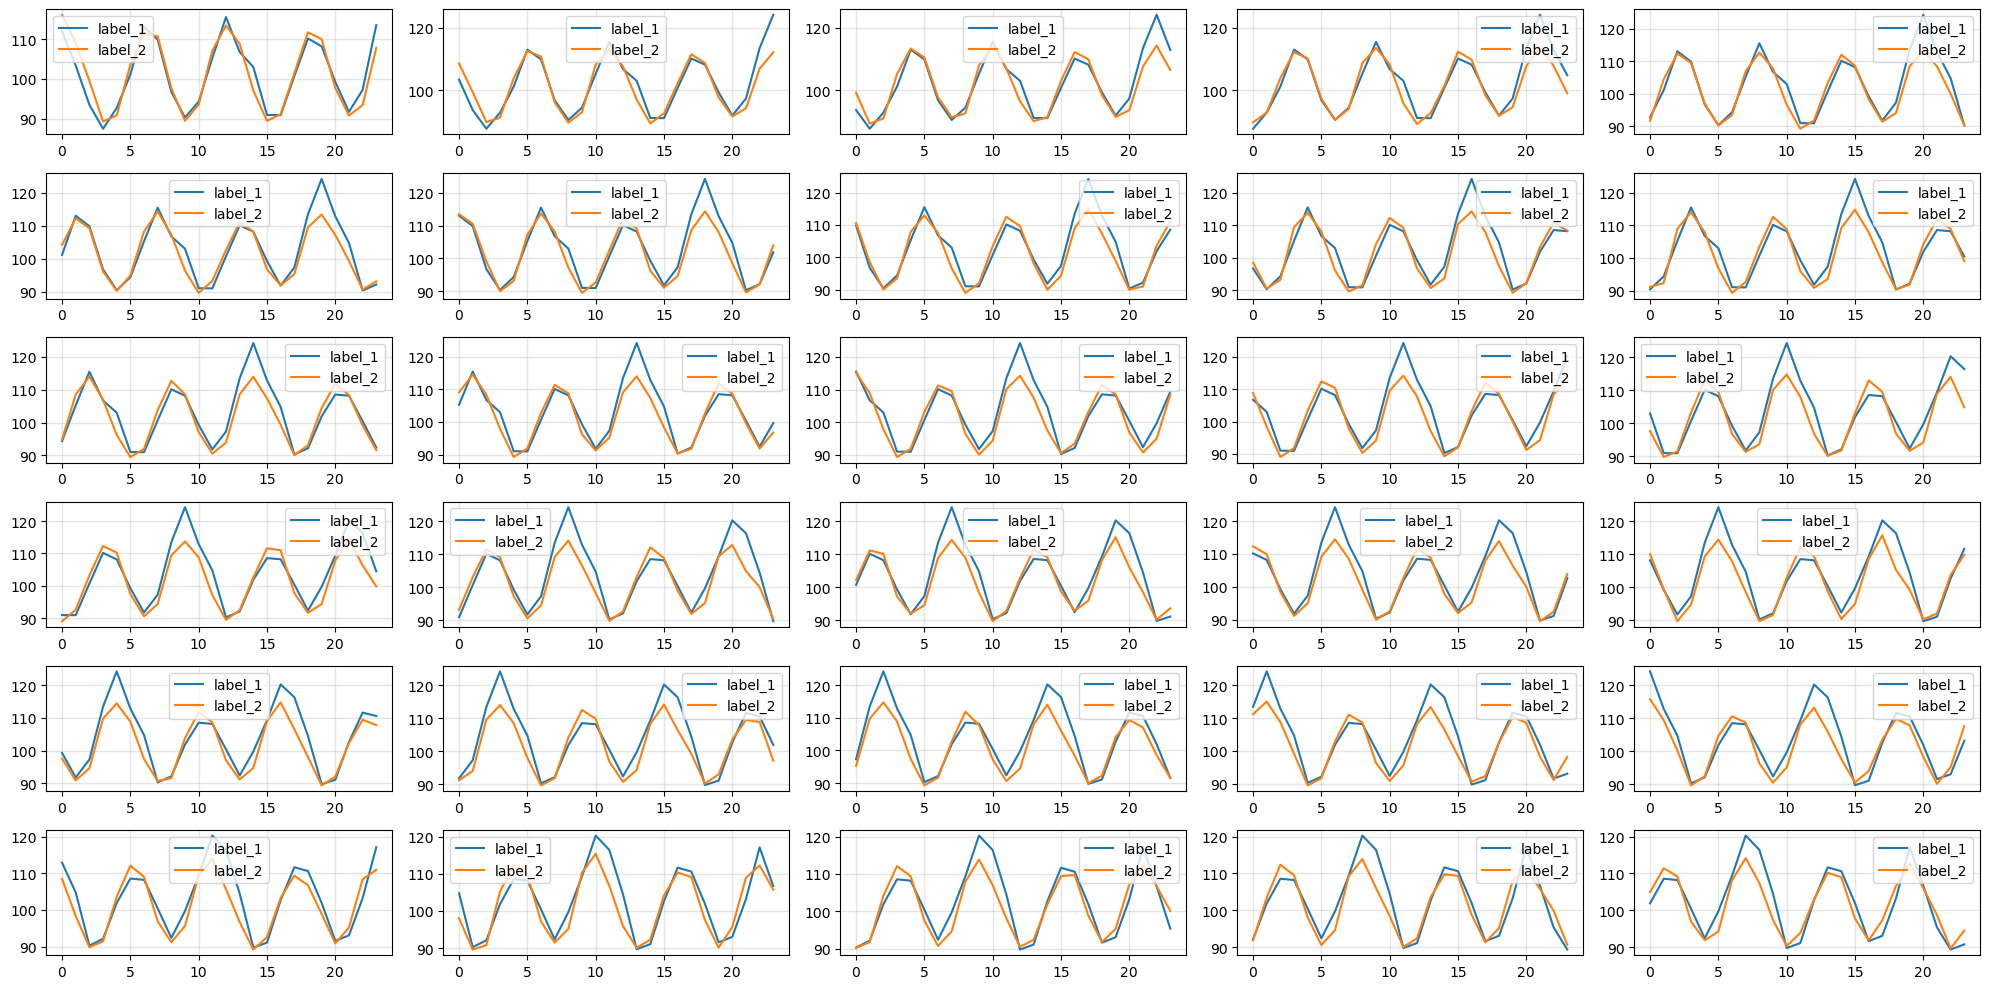

In [8]:
from spinesTS.metrics import *
from catboost import CatBoostRegressor
wide_gbrt = WideGBRT(model=CatBoostRegressor(use_best_model=True))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')